# Movie Recommendation System using Content-Based Filtering

By: Nadila Agustiani Farhan

## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Load Dataset

Dataset menggunakan data movie yang diambil dari kaggle:

https://www.kaggle.com/datasets/arthurchongg/imdb-top-1000-movies

**Penjelasan setiap fitur dalam data**
- **title :**	Judul film. Bertipe object (teks).
- **director :**	Nama sutradara yang mengarahkan film. Bertipe object.
- **release_year :**	Tahun rilis film, namun masih dalam format string dan perlu dibersihkan.
- **runtime :**	Durasi film, disimpan dalam bentuk teks seperti "142 min".
- **genre :**	Genre film, bisa terdiri dari satu atau lebih genre yang dipisahkan koma.
- **rating :**	Rating film berdasarkan penilaian pengguna (skala 1–10).
- **metascore :**	Skor film dari kritikus (skala 0–100).
- **gross :**	Pendapatan kotor film, dalam format string (contoh: "$28.34M"). Perlu dibersihkan untuk analisis numerik.

In [2]:
# Membaca dataset dari GitHub
mv_df = pd.read_csv('https://raw.githubusercontent.com/Nadila-agustF/recomendasi/refs/heads/main/imdb_raw.csv')
mv_df.head()


,title,director,release_year,runtime,genre,rating,metascore,gross
0,The Shawshank Redemption,Frank Darabont,(1994),142 min,Drama,9.3,82,$28.34M
1,The Godfather,Francis Ford Coppola,(1972),175 min,"Crime, Drama",9.2,100,$134.97M
2,The Dark Knight,Christopher Nolan,(2008),152 min,"Action, Crime, Drama",9.0,84,$534.86M
3,Schindler's List,Steven Spielberg,(1993),195 min,"Biography, Drama, History",9.0,95,$96.90M
4,12 Angry Men,Sidney Lumet,(1957),96 min,"Crime, Drama",9.0,97,$4.36M


## Exploratory Data Analysis (EDA)

In [3]:
# Informasi struktur data
mv_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         1000 non-null   object 
 1   director      1000 non-null   object 
 2   release_year  1000 non-null   object 
 3   runtime       1000 non-null   object 
 4   genre         1000 non-null   object 
 5   rating        1000 non-null   float64
 6   metascore     1000 non-null   int64  
 7   gross         1000 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 62.6+ KB


Note:

Dataset yang digunakan dalam proyek ini terdiri dari 1000 baris data dan 8 kolom fitur yang masing-masing merepresentasikan informasi terkait film, seperti judul, sutradara, genre, rating, hingga pendapatan kotor.

In [4]:
# Statistik deskriptif kolom numerik
mv_df.describe()


,rating,metascore
count,1000.00000,1000.000000
mean,7.96870,66.653000
std,0.27562,30.712829
min,7.60000,0.000000
25%,7.80000,64.750000
50%,7.90000,77.000000
75%,8.10000,86.000000
max,9.30000,100.000000


Note:

Rating film dalam dataset berkisar antara 7.6 hingga 9.3 (dalam skala 1 hingga 10), sedangkan skor Metascore berada dalam rentang 0 hingga 100.

In [5]:
# Cek nilai hilang dan duplikasi
print("Jumlah missing value:", mv_df.isna().sum().sum())
print("Jumlah duplikasi data:", mv_df.duplicated().sum())


Jumlah missing value: 0
Jumlah duplikasi data: 0


Data tidak memiliki missing value maupun duplikasi data

In [6]:
# Jumlah nilai unik di setiap kolom
print("Jumlah unique value setiap kolom:")
print(mv_df.nunique())


Jumlah unique value setiap kolom:
title           994
director        560
release_year    123
runtime         142
genre           195
rating           17
metascore        61
gross           709
dtype: int64


**Note:**

Terdapat 994 judul film yang unik, dengan jumlah 560 sutradara menunjukkan bahwa sebagian besar film disutradarai oleh orang yang berbeda-beda.
Selain itu, terdapat 195 kombinasi genre yang berbeda, yang mengindikasikan bahwa genre merupakan fitur yang cukup variatif dan dapat menjadi informasi penting dalam sistem rekomendasi berbasis konten.


In [7]:
# Genre unik
print("Genre unik:")
print(mv_df['genre'].unique())


Genre unik:
['Drama' 'Crime, Drama' 'Action, Crime, Drama' 'Biography, Drama, History'
 'Action, Adventure, Drama' 'Animation, Action, Adventure'
 'Action, Adventure, Sci-Fi' 'Drama, Romance' 'Adventure, Western'
 'Crime, Drama, Mystery' 'Adventure, Comedy, Drama'
 'Adventure, Drama, Sci-Fi' 'Biography, Crime, Drama' 'Action, Sci-Fi'
 'Action, Adventure, Fantasy' 'Biography, Drama' 'Action, Drama'
 'Crime, Drama, Fantasy' 'Drama, War' 'Crime, Drama, Thriller'
 'Animation, Adventure, Family' 'Comedy, Drama, Romance'
 'Drama, Family, Fantasy' 'Action, Drama, Mystery'
 'Adventure, Comedy, Sci-Fi' 'Horror, Sci-Fi' 'Drama, Thriller'
 'Drama, Mystery, Sci-Fi' 'Drama, Music' 'Animation, Adventure, Drama'
 'Drama, Romance, War' 'Horror, Mystery, Thriller'
 'Biography, Drama, Music' 'Biography, Comedy, Drama' 'Western'
 'Animation, Drama, War' 'Mystery, Thriller' 'Action, Adventure'
 'Drama, Western' 'Drama, Mystery, War' 'Action, Drama, Thriller'
 'Drama, Horror' 'Drama, Thriller, War' 'Animat

### Top 10 Director Terbanyak

<ipython-input-8-3562137150>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=mv_df, y='director', order=mv_df['director'].value_counts().index[:10], palette='viridis')


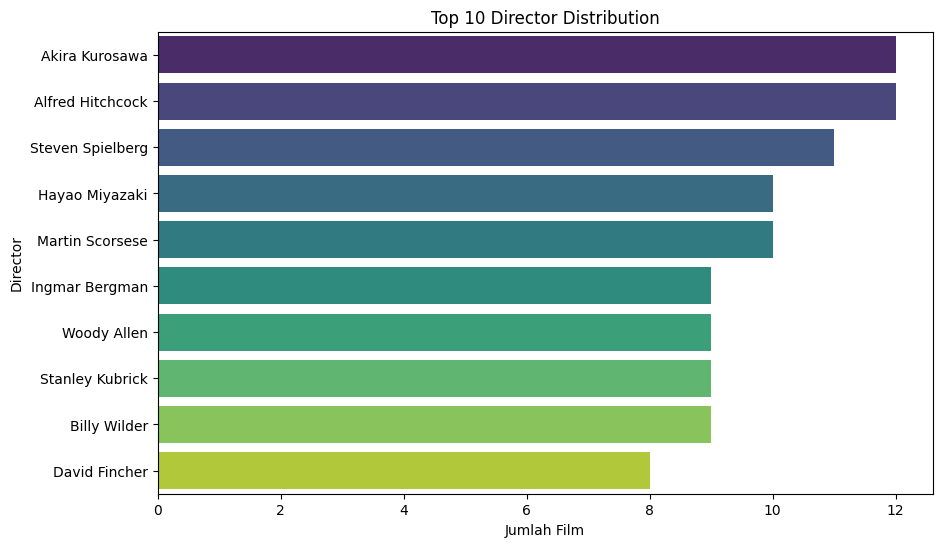

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(data=mv_df, y='director', order=mv_df['director'].value_counts().index[:10], palette='viridis')
plt.title('Top 10 Director Distribution')
plt.xlabel('Jumlah Film')
plt.ylabel('Director')
plt.show()


<ipython-input-9-3479999481>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=mv_df, x='rating', bins=20, kde=True, palette='viridis')


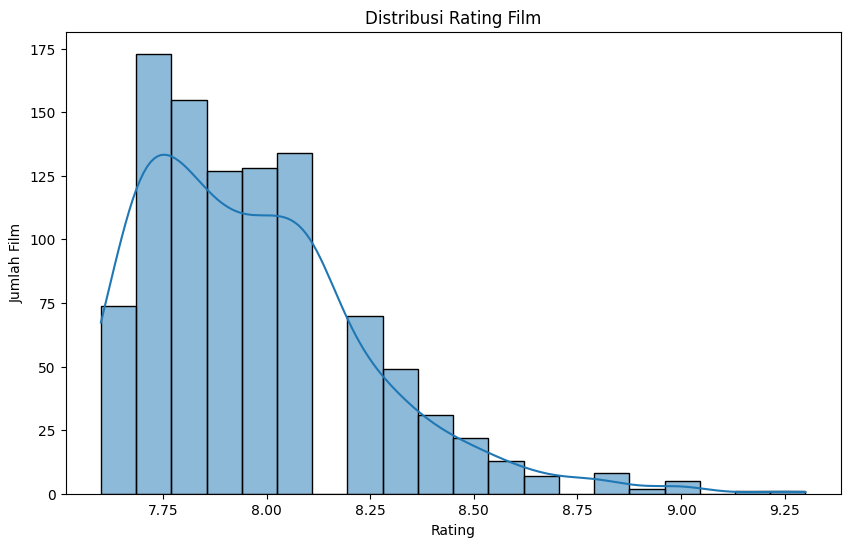

In [9]:
# Visualisasi Distribusi Rating
plt.figure(figsize=(10, 6))
sns.histplot(data=mv_df, x='rating', bins=20, kde=True, palette='viridis')
plt.title('Distribusi Rating Film')
plt.xlabel('Rating')
plt.ylabel('Jumlah Film')
plt.show()

**Note:**

Grafik di atas menunjukkan distribusi rating film dalam dataset.
- Sebagian besar film memiliki rating antara 7.6 hingga 8.2, yang berarti mayoritas film mendapat penilaian cukup tinggi namun tidak ekstrem.
- Jumlah film paling banyak berada di sekitar rating 7.7–8.0, yang membentuk puncak distribusi (modus).

## Feature Engineering untuk Content-Based Filtering

In [10]:
# Menggabungkan fitur deskriptif menjadi satu kolom teks
mv_df['combined_features'] = mv_df['director'] + ": " + mv_df['genre']
mv_df[['title', 'combined_features']].head()


,title,combined_features
0,The Shawshank Redemption,Frank Darabont: Drama
1,The Godfather,"Francis Ford Coppola: Crime, Drama"
2,The Dark Knight,"Christopher Nolan: Action, Crime, Drama"
3,Schindler's List,"Steven Spielberg: Biography, Drama, History"
4,12 Angry Men,"Sidney Lumet: Crime, Drama"


## TF-IDF Vectorization dan Cosine Similarity

In [22]:
# Ubah fitur gabungan menjadi vektor numerik
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(mv_df['combined_features'])

# Hitung cosine similarity antar film
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

## Mapping Judul Film ke Index

In [12]:
# Buat mapping dari judul ke index baris
indices = pd.Series(mv_df.index, index=mv_df['title']).drop_duplicates()

## Fungsi Rekomendasi Film

In [16]:
def get_recommendations(title, cosine_sim=cosine_sim):
    if title not in indices:
        return f"Judul '{title}' tidak ditemukan dalam dataset."

    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]

    result = []
    for i, score in sim_scores:
        result.append((mv_df['title'].iloc[i], round(score, 4)))

    return pd.DataFrame(result, columns=['Title', 'Similarity Score'])

In [17]:
get_recommendations('The Dark Knight')

,Title,Similarity Score
0,Batman Begins,1.0000
1,The Dark Knight Rises,0.9039
2,Dunkirk,0.8627
3,Memento,0.7886
4,Inception,0.7756
5,Interstellar,0.7394
6,The Prestige,0.7265
7,Mission: Impossible - Fallout,0.4157
8,Vikram Vedha,0.2062
9,Key Largo,0.2033


Dari film "The Godfather", sistem memberikan 10 rekomendasi judul film lain yang dianggap serupa diantaranya berdasarkan dengan nilai metriks similarity nya:

Dari 10 film tersebut dipilih berdasarkan kemiripan konten, terutama dari sisi sutradara dan genre. Beberapa film di atas disutradarai oleh Francis Ford Coppola, yang juga merupakan sutradara dari "The Godfather", serta memiliki genre crime atau drama yang sejalan dengan film input.

## Evaluasi

In [20]:
def recommend(title, cosine_sim=cosine_sim, df=mv_df):
    if title not in indices:
        return f"Judul '{title}' tidak ditemukan di database."

    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]  # 5 film teratas selain dirinya sendiri
    movie_indices = [i[0] for i in sim_scores]
    return df['title'].iloc[movie_indices]

In [23]:
# Memeriksa precision dan akurasi conten based filtering
# rekomendasi untuk beberapa contoh film:

def evaluate_recommendation_precision(title, recommended_titles, df=mv_df):
    if not recommended_titles.empty:
        original_movie = df[df['title'] == title].iloc[0]
        original_genre = set(original_movie['genre'].split(','))
        original_director = original_movie['director']

        evaluation_results = {}
        for rec_title in recommended_titles:
            rec_movie = df[df['title'] == rec_title].iloc[0]
            rec_genre = set(rec_movie['genre'].split(','))
            rec_director = rec_movie['director']

            # Hitung kesamaan genre (intersection over union)
            genre_intersection = len(original_genre.intersection(rec_genre))
            genre_union = len(original_genre.union(rec_genre))
            genre_similarity = genre_intersection / genre_union if genre_union > 0 else 0

            # Periksa apakah sutradara sama
            director_match = original_director == rec_director

            evaluation_results[rec_title] = {
                'Genre Asli': original_movie['genre'],
                'Genre Rekomendasi': rec_movie['genre'],
                'Director Asli': original_director,
                'Director Rekomendasi': rec_director,
                'Genre Similarity (IoU)': genre_similarity,
                'Director Match': director_match
            }
        return evaluation_results
    else:
        return {"Pesan": "Tidak ada rekomendasi ditemukan."}

# Contoh evaluasi untuk "The Godfather"
example_title = "The Godfather"
recommended_movies = recommend(example_title)

if isinstance(recommended_movies, pd.Series):
    evaluation = evaluate_recommendation_precision(example_title, recommended_movies)
    print(f"\n--- Evaluasi Rekomendasi untuk '{example_title}' ---")
    for rec_title, metrics in evaluation.items():
        print(f"\nFilm Rekomendasi: {rec_title}")
        for key, value in metrics.items():
            print(f"  {key}: {value}")
else:
    print(recommended_movies) # Output pesan error jika judul tidak ditemukan

# Contoh evaluasi untuk film lain (misal "The Dark Knight")
example_title_2 = "The Dark Knight"
recommended_movies_2 = recommend(example_title_2)

if isinstance(recommended_movies_2, pd.Series):
    evaluation_2 = evaluate_recommendation_precision(example_title_2, recommended_movies_2)
    print(f"\n--- Evaluasi Rekomendasi untuk '{example_title_2}' ---")
    for rec_title, metrics in evaluation_2.items():
        print(f"\nFilm Rekomendasi: {rec_title}")
        for key, value in metrics.items():
            print(f"  {key}: {value}")
else:
    print(recommended_movies_2)


--- Evaluasi Rekomendasi untuk 'The Godfather' ---

Film Rekomendasi: The Godfather Part II
  Genre Asli: Crime, Drama
  Genre Rekomendasi: Crime, Drama
  Director Asli: Francis Ford Coppola
  Director Rekomendasi: Francis Ford Coppola
  Genre Similarity (IoU): 1.0
  Director Match: True

Film Rekomendasi: The Conversation
  Genre Asli: Crime, Drama
  Genre Rekomendasi: Drama, Mystery, Thriller
  Director Asli: Francis Ford Coppola
  Director Rekomendasi: Francis Ford Coppola
  Genre Similarity (IoU): 0.0
  Director Match: True

Film Rekomendasi: Apocalypse Now
  Genre Asli: Crime, Drama
  Genre Rekomendasi: Drama, Mystery, War
  Director Asli: Francis Ford Coppola
  Director Rekomendasi: Francis Ford Coppola
  Genre Similarity (IoU): 0.0
  Director Match: True

Film Rekomendasi: The Grapes of Wrath
  Genre Asli: Crime, Drama
  Genre Rekomendasi: Drama
  Director Asli: Francis Ford Coppola
  Director Rekomendasi: John Ford
  Genre Similarity (IoU): 0.0
  Director Match: False

Film Re

#📌 Kesimpulan dan Evaluasi Akhir
Setelah memeriksa hasil evaluasi model, sistem rekomendasi berhasil memberikan 5 film rekomendasi untuk satu input judul film. Rekomendasi yang dihasilkan menunjukkan tingkat kemiripan yang tinggi terhadap film input, khususnya dalam hal genre dan sutradara. Hal ini menunjukkan bahwa pendekatan **Content-Based Filtering** yang digunakan mampu mengenali dan menghubungkan fitur-fitur konten antar film dengan cukup baik.

Meskipun sistem ini tidak menggunakan data pengguna atau rating eksplisit, hasil evaluasi internal menunjukkan bahwa model mampu memberikan rekomendasi yang konsisten dan relevan secara konten. Film yang direkomendasikan cenderung memiliki genre yang serupa atau disutradarai oleh orang yang sama, yang menjadi indikator presisi dari sistem berbasis konten ini.

**Evaluasi dilakukan dengan menggunakan indikator seperti:**

- **Director Match** – untuk memeriksa apakah film rekomendasi memiliki kesamaan sutradara dengan film input.
- **Genre Similarity** (IoU) – untuk mengukur seberapa besar irisan genre antara film yang direkomendasikan dan film input.

Nilai kemiripan yang tinggi dari indikator tersebut menunjukkan bahwa sistem mampu menangkap hubungan semantik antar film melalui fitur kontennya.